# Load The Dataset

Let's load the cleaned up dataset from the previous step and make a sanity
check it's alright.

In [257]:
import joblib
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

FIG_DIR = "../flask/static"

In [258]:
df = joblib.load("df.pkl")

In [259]:
df.head()

,Age [years],Anaemia,Creatine Phosphokinase [mcg/L],Diabetes,Ejection Fraction [%],High Blood Pressure,Platelets [1000 platelets/mL],Serum Creatinine [mg/dL],Serum Sodium [mEq/L],Male,Smoking,Time [days],DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1


In [260]:
df.shape

(299, 13)

We can see everything is as expected:
- there is 299 patients like previously
- column names include units and better formatting

# Split the data into train and test sets
It is time to split the dataset into train and test sets.
As explained in the previous post, we're going to select the patients 
in the following categories:
- **survivors**: survived _at least_ the first $100$ days
- **deceased** ones: passed away _within_ the first $100$ days

In [261]:
def select_df(n=100):
    """Select the patients that survived / didn't the first n days"""
    select = (((df['DEATH_EVENT'] == 0) & (df['Time [days]'] > n)) |
              ((df['DEATH_EVENT'] == 1) & (df['Time [days]'] < n)))
    return df[select]


df = select_df()

# Remove not useful features
df = df.drop(["Time [days]"], axis=1)
df.head()

,Age [years],Anaemia,Creatine Phosphokinase [mcg/L],Diabetes,Ejection Fraction [%],High Blood Pressure,Platelets [1000 platelets/mL],Serum Creatinine [mg/dL],Serum Sodium [mEq/L],Male,Smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,1


In [262]:
df.shape

(219, 12)

There are $219$ patients in this category.
It's a small statistics, which implies a few things:
- If we split train/test set in the $60\%/40\%$ ratio, we'll end up with
  around $130$ and $90$ patients in the respective categories
- It's likely to overtrain a model given a big number of features relative to the dataset size

To tackle the problem, we must rely on a simple classifier, perhaps with reduced
number of features.

Let's proceed step-by-step, starting with splitting the dataset into the
train and test sets in the $60\%/40\%$ ratio.

In [396]:
from sklearn.model_selection import train_test_split

In [397]:
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)

In [398]:
train_set['DEATH_EVENT'].value_counts()

0    88
1    43
Name: DEATH_EVENT, dtype: int64

We end up with $88$ surviving and $43$ deceased patients in the training set.

Now, we'll separate the features from the labels.

In [266]:
# drop labels and time for training set
X_train = train_set.drop(["DEATH_EVENT"], axis=1)
y_train = train_set["DEATH_EVENT"].copy()
# drop labels and time for test set
X_test = test_set.drop(["DEATH_EVENT"], axis=1)
y_test = test_set["DEATH_EVENT"].copy()

# Scale features and make a pipeline

Many algorithms require all parameters to be of the same scale.
More precisely, the features might be _normalised_ by mapping onto the $[0,1]$
range, or _standardised_ by subtracting the mean and dividing by the
standard deviation, making sure the results will have unit variance.

The former might be preferable for neural networks that require $[0, 1]$-range
input. The latter, on the other hand, are less impacted by the outliers.
Since we'll be focused on simpler classifiers _standardisation_ should be
a better choice.

Moreover, we'll put the scaling procedure in a pipeline for easier
reproducibility. Were there more preprocessing steps needed, we would
add them in the pipeline as well.

In [267]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [268]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_tr = pipeline.fit_transform(X_train)

In [269]:
X_train_tr

array([[-1.13, -0.84, -0.06, ..., -0.62,  0.72, -0.7 ],
       [-0.46, -0.84,  0.17, ...,  0.75,  0.72,  1.43],
       [ 0.21,  1.19,  1.  , ...,  0.06,  0.72, -0.7 ],
       ...,
       [-0.88, -0.84, -0.47, ..., -0.62,  0.72,  1.43],
       [-0.21, -0.84, -0.46, ...,  0.52,  0.72, -0.7 ],
       [ 0.21,  1.19, -0.06, ...,  0.06,  0.72,  1.43]])

That was just a technical check. We'll actually use standardisation later on.

# Dimensionality Reduction with PCA

To simplify the model, perhaps some features can be skipped with no big loss
to the performance and increased generalisation.
To this end we'll use the Principal Component Analysis (PCA) that projects
the features onto hyperplanes preserving most of the variance. Each successive plane is orthogonal to the previous ones and has the largest remaining variance of the dataset. Intuitively, the bigger the variance, the better resolution we have to then separate instances of various classes.

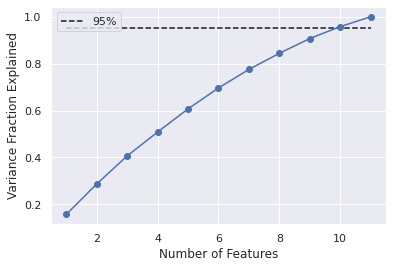

In [408]:
from sklearn.decomposition import PCA

pca = PCA()
# It's important to standardise features before PCA
# or else features that are just big will artificially have big variance.
pca.fit(X_train_tr)

def plot_explained_variance():
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum)+1), cumsum, 'o-')
    plt.xlabel("Number of Features")
    plt.ylabel("Variance Fraction Explained")
    n_features = X_train_tr.shape[1]
    plt.hlines(y=0.95, xmin=1, xmax=n_features, linestyles='dashed',
               color='k', label='95%')
    plt.legend(loc='best')
plot_explained_variance()

We can see that 10 features are required to preserve $95\%$ of the total variance.
This could be obtained more directly, but without visualisation as follows.

In [271]:
pca = PCA(n_components=0.95)

pca.fit_transform(X_train_tr)
pca.components_.T.shape # 11 x 10 matrix -> reduce to 10 dimensions

(11, 10)

Later on, we'll use PCA in a grid search to find whether it helps improve
the results and, if so, how many components are useful.

# Logistic Regression Classifier
Since we don't have much data, it's better to focus on simple classifiers.
Otherwise, we risk overtraining.

Logistic regression is one of the simplest classifiers.
Let's train it first.

In [279]:
from sklearn.linear_model import LogisticRegression
# #log_reg = LogisticRegression(penalty='l2', C=1.0, random_state=0,
#                              n_jobs=-1)

In [280]:
# Cross validation
from sklearn.model_selection import cross_val_score

In [281]:
scores = cross_val_score(log_reg, X_train_tr, y_train,
                         scoring="f1", cv=2)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

Scores: [0.55 0.63]
Mean score: 0.5923852183650617
Std dev: 0.039193729003359434


In [282]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(log_reg, X_train_tr, y_train, cv=2)
confusion_matrix(y_train, y_train_pred)

array([[71, 17],
       [18, 25]])

In [283]:
from sklearn.metrics import precision_score, recall_score

In [284]:
precision_score(y_train, y_train_pred)

0.5952380952380952

In [285]:
# precision = TP / (TP + FP)
25 / (25 + 17)

0.5952380952380952

In [286]:
recall_score(y_train, y_train_pred)

0.5813953488372093

In [287]:
# recall = TP / (TP + FN)
25 / (25 + 18)

0.5813953488372093

In [288]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.5882352941176471

### Hyperparameter Tuning and Regularisation

These hyperparameter questions we want to find answers to with a help of the grid search:
- Whether to use PCA or not; if so, how many components?
- Regularisation: Ridge ($\ell_2$), Lasso ($\ell_1$) or Elastic Net (in-between)
- Class weight: shall the class imabalance be accounted for by attributing bigger weights to less common class (i.e. patients that passed away)?
- Which solver to use in the training algorithm? This depends:
  - liblinear is good for small datasets
  - Elastic Net is supported only by the saga solver

Besides, how many folds should be used in $k-$fold validation?
Since in each iteration the model is trained on $k-1$ folds and tested on the remaining one,
to ensure the test is reliable, we'd better not reduced it too much.
Therefore, splitting our roughly $120$ patients into $2-3$ folds should be the upper limit.

The **metric** we want to optimise should not be accuracy as it is sensitive
to the class imbalance. Instead, precision and recall seem more pertinant, or their harmonic average, $F_1 = \frac{2}{1/P + 1/R}$, where $P$ and $R$ stand for precision and recall respectively and are computed as:
precision = $TP / (TP + FP)$ ("purity" of the positive-labeled group)
and recall = $TP / (TP + FN)$ (i.e. "have we labeled all the positive guys as such?").

In [289]:
# Let's optimise Logistic Regression
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('std_scaler', StandardScaler()),    
    ('pca', PCA()),
    ('clf', LogisticRegression()),
])

param_grid = [
    {'pca': ['passthrough', PCA(1), PCA(3), PCA(9), PCA(10), PCA(11)],
     'clf__penalty': ['l2', 'l1'],
     'clf__C': [.1, .5, .75, 1.0, 1.25, 1.50, 1.75, 2.0],
     'clf__class_weight': [None, 'balanced'],
     'clf__solver': ['liblinear'],  # good for small datasets
     'clf__random_state': [42]
     },
    # Elastic net is only supported by the ‘saga’ solver
    # and it requires l1_ratio parameter.
    {'pca': ['passthrough', PCA(1), PCA(3), PCA(9), PCA(10), PCA(11)],
     'clf__penalty': ['elastic_net'],
     'clf__C': [.1, .5, .75, 1.0, 1.25, 1.50, 1.75, 2.0],
     'clf__class_weight': [None, 'balanced'],
     'clf__solver': ['saga'],
     'clf__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
     'clf__random_state': [42]
     }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:    2.4s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__penalty': ['l2', 'l1'],
                          'clf__random_state': [42],
                          'clf__solver': ['liblinear'],
                          'pca': ['passthrough', PCA(n_components=1),
                                  P...
                         {'clf__C': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
                          'clf__penalty': ['elastic_net'],
                          'clf__random_state': [42]

In [290]:
grid_search.best_params_

{'clf__C': 0.75,
 'clf__class_weight': None,
 'clf__penalty': 'l1',
 'clf__random_state': 42,
 'clf__solver': 'liblinear',
 'pca': 'passthrough'}

In [291]:
log_clf = grid_search.best_estimator_
log_clf

Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', 'passthrough'),
                ('clf',
                 LogisticRegression(C=0.75, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [292]:
cvres = grid_search.cv_results_

In [293]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.5720823798627002 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': 'passthrough'}
0.08347826086956522 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': PCA(n_components=1)}
0.18406593406593408 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': PCA(n_components=3)}
0.5202702702702702 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': PCA(n_components=9)}
0.5184770436730123 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': PCA(n_components=10)}
0.5720823798627002 {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'pca': PCA(n_components=11)}
0.2682926829

F1 = .6

In [294]:
def best_score(grid_search):
    res = pd.DataFrame(grid_search.cv_results_)
    argmax = res['mean_test_score'].argmax()
    max_score = res['mean_test_score'].iloc[argmax]
    max_score_std = res['std_test_score'].iloc[argmax]
    return max_score, max_score_std


def print_best_score(grid_search):
    x, xerr = best_score(grid_search)
    print("Best score: {:.2f} +/- {:.2f}".format(x, xerr))


print_best_score(grid_search)

Best score: 0.61 +/- 0.04


In [295]:
y_train[:5]

223    0
179    0
200    0
2      1
133    0
Name: DEATH_EVENT, dtype: int64

In [296]:
grid_search.predict(X_train[:5])

array([0, 0, 0, 0, 0])

In [297]:
grid_search.predict_proba(X_train[:5])

array([[0.91, 0.09],
       [0.9 , 0.1 ],
       [0.9 , 0.1 ],
       [0.56, 0.44],
       [0.87, 0.13]])

The fourth patient was predicted as likely to survive despite actually
passing away. Looking at the probablities, though, the classifier attributed
only $56\%$ chance of surviving. Quite 'on the fence' regarding the 
limited statistics. Not bad! Of course, it's merely a technical check up, since
we used the train set.

# Random Forest Classifier

In [298]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_tr, y_train)

RandomForestClassifier(random_state=42)

In [299]:
scores = cross_val_score(forest_clf, X_train_tr, y_train,
                         scoring="f1", cv=2)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

Scores: [0.54 0.57]
Mean score: 0.554006968641115
Std dev: 0.017421602787456414


In [300]:
len(df.columns)-2

10

In [301]:
pipeline = Pipeline([
    #('time_bin', TimeBinning(bin_size=30)),
    ('std_scaler', StandardScaler()),
    ('clf', RandomForestClassifier(max_features=10, random_state=42))
])

In [302]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {  # 'time_bin__bin_size': [1, 2, 3, 4, 5],
        'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50],
        'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(pipeline, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(max_features=10,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11],
                          'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50]}],
             return_train_score=True, scoring='f1')

In [303]:
grid_search.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_features=5, n_estimators=50,
                                        random_state=42))])

In [304]:
grid_search.best_params_

{'clf__max_features': 5, 'clf__n_estimators': 50}

In [305]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_features,param_clf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.010302,0.000030,0.004192,0.000089,1,2,"{'clf__max_features': 1, 'clf__n_estimators': 2}",0.410256,0.076923,0.243590,1.666667e-01,76,0.777778,0.742857,0.760317,0.017460
1,0.023500,0.000695,0.005471,0.000105,1,10,"{'clf__max_features': 1, 'clf__n_estimators': 10}",0.315789,0.240000,0.277895,3.789474e-02,75,1.000000,0.976744,0.988372,0.011628
2,0.042416,0.000463,0.007136,0.000147,1,20,"{'clf__max_features': 1, 'clf__n_estimators': 20}",0.352941,0.230769,0.291855,6.108597e-02,74,1.000000,1.000000,1.000000,0.000000
3,0.049576,0.006877,0.007290,0.000299,1,21,"{'clf__max_features': 1, 'clf__n_estimators': 21}",0.400000,0.400000,0.400000,3.925231e-17,62,1.000000,1.000000,1.000000,0.000000
4,0.056624,0.006205,0.008853,0.000360,1,22,"{'clf__max_features': 1, 'clf__n_estimators': 22}",0.411765,0.222222,0.316993,9.477124e-02,73,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.040331,0.001088,0.006114,0.000189,11,20,"{'clf__max_features': 11, 'clf__n_estimators':...",0.470588,0.564103,0.517345,4.675716e-02,31,1.000000,1.000000,1.000000,0.000000
73,0.041691,0.000015,0.006120,0.000065,11,21,"{'clf__max_features': 11, 'clf__n_estimators':...",0.465116,0.536585,0.500851,3.573454e-02,40,1.000000,1.000000,1.000000,0.000000
74,0.044738,0.001508,0.006189,0.000193,11,22,"{'clf__max_features': 11, 'clf__n_estimators':...",0.432432,0.564103,0.498267,6.583507e-02,43,1.000000,1.000000,1.000000,0.000000
75,0.047781,0.006322,0.004622,0.000221,11,30,"{'clf__max_features': 11, 'clf__n_estimators':...",0.500000,0.611111,0.555556,5.555556e-02,11,1.000000,1.000000,1.000000,0.000000


In [306]:
print_best_score(grid_search)

Best score: 0.61 +/- 0.06


In [307]:
feature_importances = grid_search.best_estimator_._final_estimator.feature_importances_

In [308]:
sorted(zip(feature_importances, [
       col for col in df.columns if col != 'DEATH_EVENT']), reverse=True)

[(0.21648613313287135, 'Ejection Fraction [%]'),
 (0.211694318004643, 'Serum Creatinine [mg/dL]'),
 (0.15741975436922348, 'Age [years]'),
 (0.11871210336246503, 'Creatine Phosphokinase [mcg/L]'),
 (0.10494607566958161, 'Platelets [1000 platelets/mL]'),
 (0.09755688886691977, 'Serum Sodium [mEq/L]'),
 (0.02180785890990473, 'Anaemia'),
 (0.02139835993319598, 'High Blood Pressure'),
 (0.020540345520868173, 'Diabetes'),
 (0.017327645219996322, 'Smoking'),
 (0.012110517010330616, 'Male')]

In [309]:
features_ranking = sorted(zip(
    [col for col in df.columns if col != 'DEATH_EVENT'], feature_importances),
                          reverse=True,
                          key=lambda x: x[1])

In [310]:
features = [x[0] for x in features_ranking]
ranks = [x[1] for x in features_ranking]

Text(0.5, 0, 'Score')

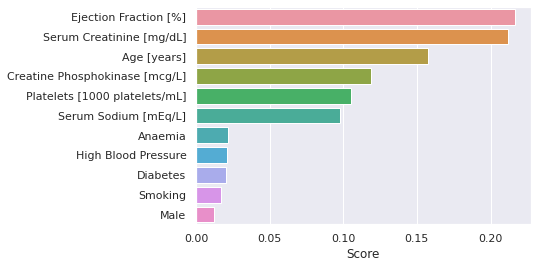

In [311]:
sns.barplot(y=features, x=ranks, orient='h')
plt.xlabel('Score')

In [312]:
best_features = features[:grid_search.best_params_['clf__max_features']]

In [313]:
rf_clf = grid_search.best_estimator_

In [314]:
from sklearn.model_selection import cross_val_predict

In [315]:
X_train_tr.shape

(131, 11)

In [316]:
y_train.shape

(131,)

In [317]:
y_probas = cross_val_predict(rf_clf, X_train_tr, y=y_train, cv=2,
                             method='predict_proba')

In [318]:
y_scores = y_probas[:, 1]

In [319]:
y_scores

array([0.2 , 0.04, 0.06, 0.44, 0.66, 0.72, 0.18, 0.22, 0.04, 0.22, 0.28,
       0.42, 0.28, 0.16, 0.66, 0.66, 0.34, 0.16, 0.6 , 0.26, 0.06, 0.26,
       0.7 , 0.72, 0.18, 0.08, 0.54, 0.86, 0.42, 0.1 , 0.52, 0.68, 0.66,
       0.56, 0.56, 0.36, 0.26, 0.66, 0.26, 0.78, 0.52, 0.2 , 0.26, 0.36,
       0.54, 0.56, 0.26, 0.28, 0.38, 0.54, 0.3 , 0.48, 0.68, 0.36, 0.02,
       0.42, 0.24, 0.28, 0.28, 0.6 , 0.5 , 0.58, 0.34, 0.6 , 0.14, 0.08,
       0.38, 0.28, 0.74, 0.48, 0.78, 0.22, 0.12, 0.48, 0.1 , 0.42, 0.38,
       0.02, 0.26, 0.04, 0.7 , 0.14, 0.52, 0.76, 0.14, 0.24, 0.28, 0.44,
       0.44, 0.8 , 0.66, 0.04, 0.08, 0.52, 0.08, 0.06, 0.7 , 0.66, 0.66,
       0.32, 0.64, 0.58, 0.42, 0.24, 0.36, 0.  , 0.16, 0.2 , 0.04, 0.24,
       0.02, 0.42, 0.28, 0.76, 0.12, 0.06, 0.2 , 0.1 , 0.16, 0.66, 0.06,
       0.18, 0.2 , 0.18, 0.02, 0.04, 0.1 , 0.54, 0.26, 0.14, 0.18])

In [320]:
#(clf.predict(X_test) == y_test).sum() / y_test.shape[0]

In [321]:
y_train[:5]

223    0
179    0
200    0
2      1
133    0
Name: DEATH_EVENT, dtype: int64

In [322]:
rf_clf.predict_proba(X_train_tr[:5])[:, 1]

array([0.42, 0.42, 0.44, 0.42, 0.46])

# SVM


In [371]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=1, loss='hinge')),
    #('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

param_grid = [{
    'svm_clf__penalty' : ['l1', 'l2'],
    'svm_clf__loss' : ['squared_hinge'],
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__class_weight' : ['balanced', None],
},
    {
    'svm_clf__penalty' : ['l2'],
    'svm_clf__loss' : ['hinge'],
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__class_weight' : ['balanced', None],   
}]
grid_search = GridSearchCV(svm_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print_best_score(grid_search)

ValueError: Invalid parameter probability for estimator LinearSVC(C=0.1, class_weight='balanced', loss='hinge'). Check the list of available parameters with `estimator.get_params().keys()`.

In [372]:
# SVM with rbf kernel
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC()),#kernel='rbf', gamma=5, C=0.001))
])

param_grid = [{
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__kernel': ['rbf', 'poly', 'sigmoid', 'precomputed'],
    'svm_clf__degree': [2, 3, 4],
    'svm_clf__gamma': ['scale', 'auto'],
    'svm_clf__coef0': [0.0, 0.1, 0.2],
    'svm_clf__class_weight' : ['balanced', None],
    'svm_clf__probability' : [True],
}]
grid_search = GridSearchCV(svm_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print_best_score(grid_search)

{'svm_clf__C': 1.5, 'svm_clf__class_weight': 'balanced', 'svm_clf__coef0': 0.0, 'svm_clf__degree': 2, 'svm_clf__gamma': 'scale', 'svm_clf__kernel': 'rbf', 'svm_clf__probability': True}
Best score: 0.67 +/- 0.01


In [373]:
svm_clf = grid_search.best_estimator_

# KNN

In [362]:
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn_clf', KNNClassifier())
])

param_grid = {
    'knn_clf__n_neighbors' : [1, 2, 3, 5],
    'knn_clf__weights' : ['uniform', 'distance'],
}

grid_search = GridSearchCV(knn_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn_clf__n_neighbors': [1, 2, 3, 5],
                         'knn_clf__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [363]:
grid_search.best_params_

{'knn_clf__n_neighbors': 1, 'knn_clf__weights': 'uniform'}

In [364]:
print_best_score(grid_search)

Best score: 0.37 +/- 0.08


In [365]:
knn_clf = grid_search.best_estimator_

# Chaining up the Classifiers

To make the most out of each classifier, we may combine them into a single one.
This is akin to voting in all sorts of whimsical _crowd wisdom_ questions (who on earth cares how many beans you have in your jar xD).

We'll be using _soft_ voting that takes into account confidence of each vote, rather than just the majority.

In [393]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), 
                ('rf', rf_clf),
                ('svm', svm_clf),
                #('knn', knn_clf),
               ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('std_scaler', StandardScaler()),
                                              ('pca', 'passthrough'),
                                              ('clf',
                                               LogisticRegression(C=0.75,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('rf',
                              Pipeline(steps=[('std_scaler', StandardScaler()),
                                              ('clf',
                                               RandomForestClassifier(max_features=5,
                                                                      n_estimators=50,
                                                                      random_state=42))])

In [394]:
f1_score.__name__

'f1_score'

In [395]:
from sklearn.metrics import accuracy_score
for name, clf in zip(('logit', 'RF', 'SVM', 'KNN', 'Ensemble'),
                     (log_clf, rf_clf, svm_clf, knn_clf, voting_clf)):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    for metric in (f1_score, precision_score, recall_score, accuracy_score):
        print(name, metric.__name__, metric(y_test, y_pred))

logit f1_score 0.5517241379310344
logit precision_score 0.5333333333333333
logit recall_score 0.5714285714285714
logit accuracy_score 0.7045454545454546
RF f1_score 0.4615384615384615
RF precision_score 0.5
RF recall_score 0.42857142857142855
RF accuracy_score 0.6818181818181818
SVM f1_score 0.6666666666666667
SVM precision_score 0.5609756097560976
SVM recall_score 0.8214285714285714
SVM accuracy_score 0.7386363636363636
KNN f1_score 0.39999999999999997
KNN precision_score 0.375
KNN recall_score 0.42857142857142855
KNN accuracy_score 0.5909090909090909
Ensemble f1_score 0.5555555555555555
Ensemble precision_score 0.5769230769230769
Ensemble recall_score 0.5357142857142857
Ensemble accuracy_score 0.7272727272727273


Random Forest has clearly overfitted in the training.
Overall accuracy is $73\%$, however this metric is not that informative:
it reflect twice as many surviving patients in the training than the deceased ones.
More useful performance measures are precision = $TP / (TP + FP)$ ("purity" of the positive-labeled group)
and recall = $TP / (TP + FN)$ (i.e. "have we labeled all the positive guys as such?").
These, end up, much lower, $precision = 58\%$ and $recall = 54\%$.

Is it still way better than a coin toss?
Well, our intuition might tempt us to compare the scores to the "obviously random $50\%$".
That's wrong! It all boils down to how many patient of each category we have in the test set,
which almost never is 50/50.

Let's implement a silly coin toss clasifier and see.

In [350]:
class CoinTossClassifier(BaseEstimator):
    def fit(self, X, y=None):
        """Nothing to fit"""
        return self
    def predict(self, X):
        """Toss a coin"""
        return np.random.randint(0, 2, size=len(X))
coin_clf = CoinTossClassifier()
(coin_clf.predict(X_test) == y_test).value_counts()

False    44
True     44
Name: DEATH_EVENT, dtype: int64

In [351]:
y_pred = coin_clf.predict(X_test)
for metric in (f1_score, precision_score, recall_score, accuracy_score):
    print(metric.__name__, metric(y_test, y_pred))

f1_score 0.3376623376623377
precision_score 0.2653061224489796
recall_score 0.4642857142857143
accuracy_score 0.42045454545454547


Indeed, the scores were below $50\%$ making our logistic regression and combined classifiers win by far!
The Random Forest classifier outperformed a random coin toss in all metrics but recall.
This happened as a result of precision-recall trade-off: RF obtained better precision than a random coin toss, but inferior recall.

This bring up the ultimate question about the project: how the algorithm output will be used?
If doctors will implement extra safety precautions for the deemed-dead patients, perhaps it's
better to be overcautious by optimising for higher recall, thereby raising false alarms.

On the other hand, if the doctors might apply a potentially dangerous operation, we'd better kept $F_1$ score high instead.

Therefore, domain knowledge and the context of the machine-learning problem are essential.

# Save the model
Let's create a new model that requires only the best features and matches the optimal grid search criteria.
Although this step may seem unnecessary as it might be incorporated in the pipeline,
it is actually needed for deployment (e.g. web application), otherwise the user will have to 
provide some unnecessary features.
However, feature scaling might be included in the pipeline. Let us then start from unscaled data and rebuild the pipeline.

In [ ]:
X_train_best_features = pd.DataFrame(
    X_train, columns=df.columns[:-1])[best_features]

In [ ]:
best_params = {k.replace('clf__', ''): v for k,
               v in grid_search.best_params_.items()}

In [ ]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('clf', RandomForestClassifier(**best_params, random_state=42))
])
pipeline.fit(X_train_best_features, y_train)

In [ ]:
scores = cross_val_score(pipeline, X_train_best_features, y_train,
                         scoring="accuracy", cv=3)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

In [ ]:
from collections import OrderedDict
import joblib
joblib.dump(pipeline, "cardio_model.pkl")
# Save feature names so that a web app knows which features are required
best_features_dict = OrderedDict({f: features_dict[f] for f in best_features})
print(best_features_dict)
joblib.dump(best_features_dict, 'features.pkl')

# Load the model

In [ ]:
# Test the model on hypothetical new cases
model = joblib.load("cardio_model.pkl")

In [ ]:
X_train_best_features[:3]

In [ ]:
y_train[:3]

In [ ]:
model.predict(X_train_best_features[:3])

**Decision regions**

In [ ]:
# def plot_decision_regions(df=X_train_best_features, clf=model,
#                           feature_x='serum_creatinine',
#                           feature_y='ejection_fraction'):
#     #print(df.head())
#     #X = (df[[feature_x, feature_y]]).values
#     print(X)
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                      np.arange(y_min, y_max, 0.1))
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     plt.scatter(df[feature_x], df[feature_y], c=y_train,
#                 cmap='plasma')
#     plt.xlabel(feature_x)
#     plt.ylabel(feature_y)
# # plot_decision_regions()
# # plot_decision_regions(feature_y='age')
# X_train_best_features.plot('age', 'serum_creatinine',
#                            kind='scatter', c=y_train)#,
#                            #cmap='gray')

In [ ]:
def foe(x, y):
    print(x, y)


foe(*[11, 22])

In [ ]:
# aranges = []
# for col in X_train_best_features.columns:
#     x_min, x_max = X_train_best_features[col].min()-1,\
#         X_train_best_features[col].max()+1
#     step = (x_max - x_min) / 20
#     arange = np.arange(x_min, x_max, step)
#     aranges.append(arange)
# #print(aranges)
# # xs = np.arange(0, 3, 0.5)
# # ys = np.arange(0, 2, 0.5)
# # merged = np.vstack((xs, ys))
# # grid = (xs, ys)
# grid = np.meshgrid(*aranges)
# grid
# #np.meshgrid(xs, ys)

In [ ]:
np.hsplit(np.array)

# Evalute model performance on the test set

In [ ]:
# TODO: Before I do it, I should implement F1 score, precision/recall, ROC curves and so on in the training.
# Otherwise I might be biased and select a model better performing on the test sample, overtraining it.

# For now, let's just trust "this model is OK" and focus on deployment.

In [ ]:
X_train_tr.shape

In [ ]:
X_train_tr_best_features.shape

In [ ]:
type(X_train_tr_best_features)

In [ ]:
df.columns

In [ ]:
best_features

In [ ]:
X_test_best_features = pd.DataFrame(
    X_test, columns=df.columns[:-1])[best_features]

In [ ]:
X_test_best_features

In [ ]:
sc = StandardScaler()

In [ ]:
sc.fit(X_train[best_features])

In [ ]:
X_test_tr = sc.transform(X_test_best_features)

In [ ]:
(model.predict(X_test_tr) == y_test).sum() / y_test.shape[0]

65% accurate model. Could be improved, but let us use it for now in the web application.